**This part of the project deals with using Logistic Regression involving predictive modeling. We undersample the dataset, and use it to find the best possible parameters for to run LR on the whole dataset. We can use either the largest Area Under Curve or the best recall score.**

**A. Import Libraries**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn
from sklearn.preprocessing import StandardScaler as SS
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, auc, roc_curve, roc_auc_score, recall_score 

%matplotlib inline

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


**A.1 Common methods definition**

In [2]:
#From SKlearn
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

**B. Load Data**

In [3]:
data = pd.read_csv("../input/creditcard.csv")

**C.1 Verify data skewness**

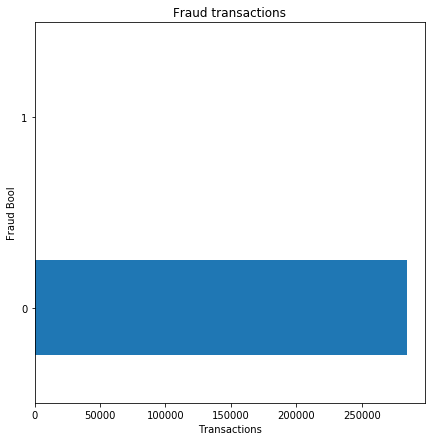

In [4]:
fig, axes = plt.subplots()
value_counts = pd.value_counts(data['Class'], dropna=True).sort_index()
drop = value_counts.plot(kind = 'barh', title = "Fraud transactions", use_index=True)
drop1 = plt.xlabel("Transactions")
drop1 = plt.ylabel("Fraud Bool")
fig.set_figheight(7)
fig.set_figwidth(7)
#plt.figure(figsize=(15,10))


**C.2 Veryfying correlation between different parameters**

This shows there is no immediate relation between the normalized parameters provided in the dataset.
We don't consider time as it is the time for each transaction and as such can is only used for chronological ordering.
We don't consider amount as it is not normalized like the rest of the attributes.

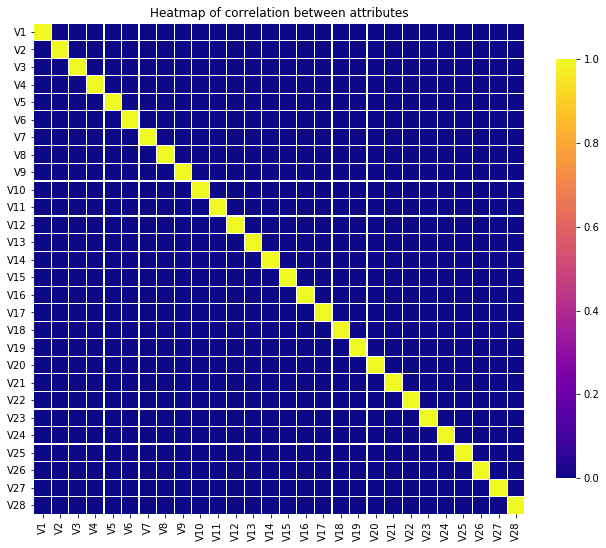

In [5]:
fig, axes = plt.subplots()
fig.set_figheight(11)
fig.set_figwidth(11)
plt.title('Heatmap of correlation between attributes')
drop = seaborn.heatmap(data.iloc[:,1:29].corr(), linewidths=.1, ax=axes, square=True, 
            cbar_kws={"shrink": .7}, cmap='plasma')

**D. Undersample Data**

Randomly choose a number of valid transactions (default is number of fraud transactions), without replacement and concatenate with fraud ones for the undersample
Use under_ratio to increase the ratio of normal transactions in the undersample
Use replacement to choose replacement strategy

In [6]:
under_ratio = 10
replacement = True
indices = np.array(np.random.choice(data[data.Class == 0].index, len(data[data.Class == 1])*under_ratio, replace = replacement))
data_undersampled = data.iloc[np.concatenate([np.array(data[data.Class == 1].index),indices]), : ]

x_undersampled = data_undersampled.loc[:, data_undersampled.columns != 'Class']
y_undersampled = data_undersampled.loc[:, data_undersampled.columns == 'Class']

#No shuffling as we will indirectly use next(ShuffleSplit().split(X, y)) later
x_original = data.loc [:, data.columns != 'Class']
y_original = data.loc [:, data.columns == 'Class']

**E.1 Using AUC as the best criterion and probability prediction :**
Find the best parameters to be used for Logistic Regression using undersampled data
Use probability prediction to fit the entire dataset**

We use the undersampled data for Logistic Regression and use the probablility prediction to find the best value of parameters. 


Best value of C is 0.10 with auc 0.98


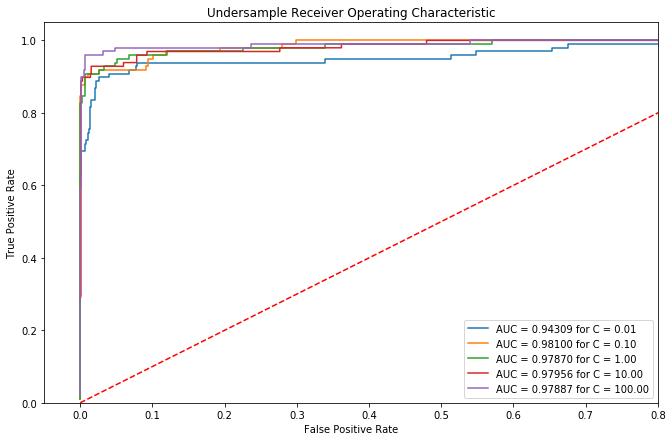

In [7]:
x_array, y_array = np.array(x_undersampled.as_matrix()), np.array(y_undersampled.Class.tolist())  
f = plt.figure(figsize = (11,7));
plt.title('Undersample Receiver Operating Characteristic')
c_vals = [0.01,0.1,1,10,100]
best_c = 0.01
max_auc = 0.0
for i in range(5):
    lr = LogisticRegression(C = c_vals[i], penalty = 'l1')
    sk = StratifiedKFold(n_splits = 5, shuffle = True)
    total_tpr, total_thresh = 0.0, 0.0
    mean_fpr = np.linspace(0, 1, 50000)  
    for train_index, test_index in sk.split(x_array, y_array):
        X_train, y_train = x_array[train_index], y_array[train_index]
        X_test, y_test = x_array[test_index], y_array[test_index]
        lr.fit(X_train, y_train)
        y_prob = lr.predict_proba(X_test)[:,lr.classes_[1]]
        fpr, tpr, thresholds = roc_curve(y_test, y_prob)
        total_tpr += np.interp(mean_fpr, fpr, tpr)
        total_thresh += np.interp(mean_fpr, fpr, thresholds)
        total_tpr[0] = 0.0
    mean_tpr = total_tpr/5
    mean_thresh = total_thresh/5
    roc_auc = auc(mean_fpr,mean_tpr)
    if roc_auc > max_auc:
        max_auc = roc_auc
        best_c = c_vals[i]
    plt.plot(fpr, tpr,label='AUC = %0.5f for C = %0.2f' % (roc_auc, c_vals[i]));
    
print ("Best value of C is %.2f with auc %.2f" % (best_c, max_auc))  

plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim(-.05, 0.8)  
plt.ylim(.0, 1.05)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

**Use values from above to run regression on the total sample **

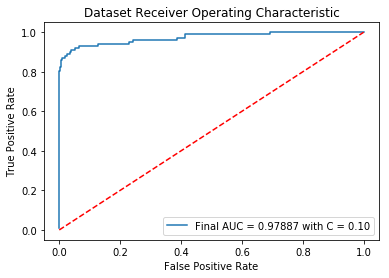

In [8]:
x_array, y_array = np.array(x_original.as_matrix()), np.array(y_original.Class.tolist())  
#f = plt.figure(figsize = (9,5));
plt.title('Dataset Receiver Operating Characteristic')
lr = LogisticRegression(C = best_c, penalty = 'l1')
sk = StratifiedKFold(n_splits = 5, shuffle = True)
total_tpr, total_thresh = 0.0, 0.0
mean_fpr = np.linspace(0, 1, 50000)  
for train_index, test_index in sk.split(x_array, y_array):
    X_train, y_train = x_array[train_index], y_array[train_index]
    X_test, y_test = x_array[test_index], y_array[test_index]
    lr.fit(X_train, y_train)
    y_prob = lr.predict_proba(X_test)[:,lr.classes_[1]]
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    total_tpr += np.interp(mean_fpr, fpr, tpr)
    total_thresh += np.interp(mean_fpr, fpr, thresholds)
    total_tpr[0] = 0.0
mean_tpr = total_tpr/5
mean_thresh = total_thresh/5
plt.plot(fpr, tpr,label='Final AUC = %0.5f with C = %0.2f' % (roc_auc, best_c));

plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

**E.2 Using Recall as the best criterion and prediction:**

Find the best parameters to be used for Logistic Regression using undersampled data
Use  prediction to fit the entire dataset

In [9]:
#f = plt.figure(figsize = (11,7));
#plt.title('Undersample Receiver Operating Characteristic (Recall)')
c_vals = [0.01,0.1,1,10,100]
best_c = 0.01
best_rec = 0.0
for i in range(5):
    lr = LogisticRegression(C = c_vals[i], penalty = 'l1')
    total_rec, total_tpr, total_thresh = 0.0, 0.0, 0.0
    for train_index, test_index in sk.split(x_array, y_array):
        X_train, X_test, y_train, y_test = train_test_split(x_undersampled, y_undersampled, test_size=0.33, random_state = 777)
        lr.fit(X_train, y_train.values.ravel())
        y_pred = lr.predict(X_train.values)
        #y_prob = lr.predict_proba(X_test)[:,lr.classes_[1]]
        rec_score = recall_score(y_train.values,y_pred)
        total_rec += rec_score
        
    mean_rec = total_rec/5
    roc_auc = auc(mean_fpr,mean_tpr)
    if mean_rec > best_rec:
        best_rec = mean_rec
        best_c = c_vals[i] 

print ("Best value of C is %.2f with undersampled recall %.2f" % (best_c, best_rec))    

Best value of C is 10.00 with undersampled recall 0.86


**Use values from above to run regression on the total sample **

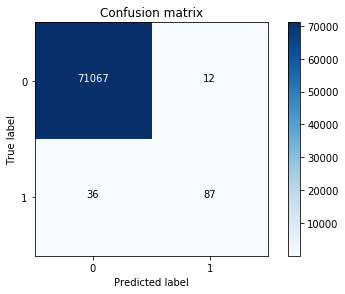

In [10]:
#Using values from the evaluation stage, we run the regression on the whole data set
X_train, X_test, y_train, y_test = train_test_split(x_original, y_original, train_size=0.75, random_state = 777)
lr = LogisticRegression(C = best_c, penalty = 'l1')
lr.fit(X_train,y_train.values.ravel())
y_predicted = lr.predict(X_test.values)

cnf_matrix = confusion_matrix(y_test,y_predicted)
plot_confusion_matrix(cnf_matrix, classes=[0,1], title='Confusion matrix')
plt.show()

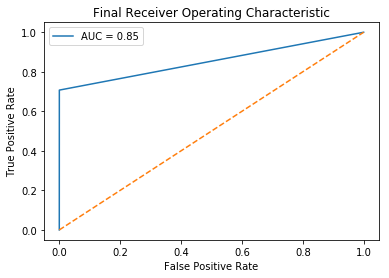

Final AUC: 0.85
Final Precision: 0.88
Final Recall: 0.71


In [11]:
#Final ROC for prediction method
fpr, tpr, th = roc_curve(y_test.values.ravel(),y_predicted)
area = auc(fpr,tpr)
plt.title('Final Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.2f'% area)
plt.legend()
plt.plot([0,1],[0,1],'--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
print("Final AUC: %0.2f\nFinal Precision: %0.2f\nFinal Recall: %0.2f" %(area, 
    cnf_matrix[1,1]/(cnf_matrix[0,1]+cnf_matrix[1,1]), cnf_matrix[1,1]/(cnf_matrix[1,1]+cnf_matrix[1,0])))